In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import gc
import os
import psutil
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML, display, Image as IPImage
import io


In [ ]:
def load_video_chunk(video_path, start_frame, num_frames, target_size=(128, 128)):
    """Load a specific chunk of video frames"""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frames = []
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV) #changed it yuv
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return None

    frames_array = np.stack(frames)
    frames_tensor = torch.from_numpy(frames_array).permute(0, 3, 1, 2)
    return frames_tensor


def get_video_info(video_path):
    """Get video metadata"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return total_frames, fps

import torch
import torch.nn.functional as F

def block_skip_preprocess(frames, block_size=8, threshold=0.01):
    """
    Args:
        frames: [B, T, C, H, W] video tensor
        block_size: size of blocks
        threshold: residual threshold for skipping
    Returns:
        processed_frames: [B, T, C, H, W] with skipped blocks zeroed
        skip_masks: [B, T, 1, H, W] binary mask (1 = encode, 0 = skip)
    """
    B, T, C, H, W = frames.shape
    processed_frames = frames.clone()
    skip_masks = torch.ones(B, T, 1, H, W, device=frames.device, dtype=frames.dtype)

    for t in range(1, T):
        prev = frames[:, t-1]  # [B, C, H, W]
        curr = frames[:, t]    # [B, C, H, W]

        # Pad to be divisible by block_size
        pad_h = (block_size - H % block_size) % block_size
        pad_w = (block_size - W % block_size) % block_size
        prev_padded = F.pad(prev, (0, pad_w, 0, pad_h))
        curr_padded = F.pad(curr, (0, pad_w, 0, pad_h))

        # Unfold into blocks: [B, C, num_blocks_h, num_blocks_w, block_size, block_size]
        prev_blocks = prev_padded.unfold(2, block_size, block_size).unfold(3, block_size, block_size)
        curr_blocks = curr_padded.unfold(2, block_size, block_size).unfold(3, block_size, block_size)

        # Compute L2 norm per block over channels + spatial block dims
        # Result shape: [B, num_blocks_h, num_blocks_w]
        block_diff = torch.sqrt(((curr_blocks - prev_blocks)**2).sum(dim=(1, -1, -2)))

        # Mask: 1=encode, 0=skip
        mask_blocks = (block_diff > threshold).float()

        # Expand mask to cover channels and block pixels
        mask_blocks = mask_blocks.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # [B,1,nh,nw,1,1]
        mask_blocks = mask_blocks.expand(-1, C, -1, -1, block_size, block_size)

        # Fold back to frame shape
        mask = mask_blocks.contiguous().view(B, C, H + pad_h, W + pad_w)[:, :, :H, :W]

        # Apply mask
        processed_frames[:, t] *= mask
        skip_masks[:, t] = mask[:, :1, :, :]  # keep 1 channel for mask

    return processed_frames, skip_masks

def plot_training_metrics(loss_history, distortion_history, rate_history, psnr_history):
    import matplotlib.pyplot as plt

    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss_history, label='Loss', marker='o')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Distortion
    plt.subplot(1, 4, 2)
    plt.plot(epochs, distortion_history, label='Distortion', marker='o', color='orange')
    plt.title('Distortion (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)

    # Rate
    plt.subplot(1, 4, 3)
    plt.plot(epochs, rate_history, label='Rate', marker='o', color='green')
    plt.title('Rate (bits)')
    plt.xlabel('Epoch')
    plt.ylabel('Rate')
    plt.grid(True)

    # PSNR
    plt.subplot(1, 4, 4)
    plt.plot(epochs, psnr_history, label='PSNR', marker='o', color='red')
    plt.title('PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('dB')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out, inplace=True)
        return out


class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_channels=24):
        super().__init__()

        # Downsampling path with residual blocks
        self.conv1 = nn.Conv2d(in_channels, 32, 5, stride=2, padding=2)  # 128->64
        self.bn1 = nn.BatchNorm2d(32)
        self.res1 = ResidualBlock(32)

        self.conv2 = nn.Conv2d(32, 48, 3, stride=2, padding=1)  # 64->32
        self.bn2 = nn.BatchNorm2d(48)
        self.res2 = ResidualBlock(48)

        self.conv3 = nn.Conv2d(48, latent_channels, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(latent_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.res1(x)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = self.res2(x)
        x = self.bn3(self.conv3(x))
        return x

class EncoderWithSkip(nn.Module):
    def __init__(self, in_channels=3, latent_channels=24):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 5, stride=2, padding=2)  # 128->64
        self.bn1 = nn.BatchNorm2d(32)
        self.res1 = ResidualBlock(32)

        self.conv2 = nn.Conv2d(32, 48, 3, stride=2, padding=1)  # 64->32
        self.bn2 = nn.BatchNorm2d(48)
        self.res2 = ResidualBlock(48)

        self.conv3 = nn.Conv2d(48, latent_channels, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(latent_channels)

    def forward(self, frames, skip_masks=None, prev_latent=None):
        """
        frames: [B, C, H, W]
        skip_masks: [B, 1, H, W] binary mask (1=encode, 0=skip)
        prev_latent: [B, latent_channels, H//4, W//4] previous frame latent (optional)
        """
        if skip_masks is not None and prev_latent is not None:
          mask = F.interpolate(skip_masks, size=prev_latent.shape[-2:], mode='nearest')
          if mask.sum() == 0:
            return prev_latent

        x = F.relu(self.bn1(self.conv1(frames)), inplace=True)
        x = self.res1(x)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = self.res2(x)
        x = self.bn3(self.conv3(x))  # latent output

        return x





class Decoder(nn.Module):
    def __init__(self, latent_channels=24, out_channels=3):
        super().__init__()

        self.conv1 = nn.Conv2d(latent_channels, 48, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        self.res1 = ResidualBlock(48)

        self.deconv1 = nn.ConvTranspose2d(48, 32, 3, stride=2, padding=1, output_padding=1)  # 32->64
        self.bn2 = nn.BatchNorm2d(32)
        self.res2 = ResidualBlock(32)

        self.deconv2 = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=2, output_padding=1)  # 64->128
        self.bn3 = nn.BatchNorm2d(16)

        self.conv_out = nn.Conv2d(16, out_channels, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.res1(x)
        x = F.relu(self.bn2(self.deconv1(x)), inplace=True)
        x = self.res2(x)
        x = F.relu(self.bn3(self.deconv2(x)), inplace=True)
        x = torch.sigmoid(self.conv_out(x))
        return x

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size=3):
        super().__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        padding = kernel_size // 2

        self.conv = nn.Conv2d(
            input_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding
        )

    def forward(self, x, hidden_state):
        h, c = hidden_state
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)

        i, f, o, g = torch.split(gates, self.hidden_channels, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, (h_next, c_next)


class TemporalPredictor(nn.Module):
    def __init__(self, latent_channels=24):
        super().__init__()
        self.latent_channels = latent_channels

        # ConvLSTM for temporal modeling
        self.conv_lstm = ConvLSTMCell(latent_channels, latent_channels)

        # Refinement network
        self.refine = nn.Sequential(
            nn.Conv2d(latent_channels, latent_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(latent_channels, latent_channels, 3, padding=1)
        )

    def forward(self, latents):
        """
        Args:
            latents: [batch, seq_len, C, H, W]
        Returns:
            predictions: [batch, seq_len, C, H, W]
        """
        batch_size, seq_len, C, H, W = latents.shape
        device = latents.device

        # Initialize hidden state
        h = torch.zeros(batch_size, C, H, W, device=device)
        c = torch.zeros(batch_size, C, H, W, device=device)
        hidden_state = (h, c)

        predictions = []

        for t in range(seq_len):
            if t == 0:
                # First frame: predict zeros (I-frame)
                pred = torch.zeros_like(latents[:, 0])
            else:
                # Predict using ConvLSTM
                h, hidden_state = self.conv_lstm(latents[:, t-1], hidden_state)
                pred = self.refine(h)

            predictions.append(pred)

        return torch.stack(predictions, dim=1)


class AdaptiveQuantizer(nn.Module):
    def __init__(self, num_levels=256):
        super().__init__()
        self.num_levels = num_levels
        self.scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        x_scaled = x * self.scale

        if self.training:
            # Soft quantization with uniform noise
            noise = (torch.rand_like(x_scaled) - 0.5)
            return x_scaled + noise
        else:
            # Hard quantization
            x_quant = torch.round(x_scaled * (self.num_levels - 1)) / (self.num_levels - 1)
            return x_quant


class ParametricEntropyModel(nn.Module):
    def __init__(self, latent_channels=24):
        super().__init__()
        self.latent_channels = latent_channels
        # Predict scale parameters for each latent (positive via softplus)
        self.scale_net = nn.Sequential(
            nn.Conv2d(latent_channels, latent_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(latent_channels, latent_channels, 3, padding=1),
            nn.Softplus()  # ensures scale > 0
        )

    def forward(self, x):
        # x: quantized latent [B, LC, H, W]
        scale = self.scale_net(x)
        return scale

    def estimate_rate(self, quantized_x):
        scale = self.forward(quantized_x)
        scale = torch.clamp(scale, min=1e-3)  # avoid zero

        # Gaussian entropy: H = 0.5 * log(2 * pi * e * scale^2)
        entropy_element = 0.5 * torch.log(2 * torch.pi * torch.exp(torch.tensor(1.0)) * scale**2 + 1e-8)

        rate = entropy_element.mean()
        return rate



class EntropyModel(nn.Module):
    def __init__(self, latent_channels=24, num_bins=256):
        super().__init__()
        self.latent_channels = latent_channels
        self.num_bins = num_bins
        self.context_net = nn.Sequential(
            nn.Conv2d(latent_channels, latent_channels * num_bins, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(latent_channels * num_bins, latent_channels * num_bins, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(latent_channels * num_bins, latent_channels * num_bins, 3, padding=1)
        )

    def forward(self, x):
        # x: [B, LC, H, W]
        # Output logits shape: [B, LC * num_bins, H, W]
        return self.context_net(x)

    def estimate_rate(self, quantized_x):
        """
        quantized_x: [B, LC, H, W], continuous quantized latents in [0,1]
        Returns estimated rate (Shannon loss) over the batch.
        """
        B, C, H, W = quantized_x.shape
        logits = self.forward(quantized_x)  # [B, LC*num_bins, H, W]

        # Reshape logits to separate channel and bins: [B, LC, num_bins, H, W]
        logits = logits.view(B, C, self.num_bins, H, W)
        # Permute to bring bins last: [B, LC, H, W, num_bins]
        logits = logits.permute(0, 1, 3, 4, 2).contiguous()
        # Flatten to 2D for NLL loss: [(B*LC*H*W), num_bins]
        logits = logits.view(-1, self.num_bins)

        # Convert quantized values to discrete symbol indices
        symbols = torch.clamp((quantized_x * (self.num_bins - 1)).round().long(), 0, self.num_bins - 1)
        # Flatten symbols to 1D: [(B*LC*H*W)]
        symbols = symbols.view(-1)

        # Compute negative log-likelihood loss (Shannon entropy)
        loss = F.nll_loss(torch.log_softmax(logits, dim=1), symbols, reduction='mean')
        return loss

    def estimate_rate_chunked(self, quantized_x, chunk_size=16):
      B, C, H, W = quantized_x.shape
      losses = []
      for i in range(0, B, chunk_size):
          chunk = quantized_x[i:i+chunk_size]
          losses.append(self.estimate_rate(chunk))
      return torch.stack(losses).mean()



In [ ]:
class VideoCompression(nn.Module):

    def __init__(self, latent_channels=24):
        super().__init__()
        self.encoder = EncoderWithSkip(3, latent_channels)
        # self.encoder = Encoder(3, latent_channels)
        self.decoder = Decoder(latent_channels, 3)
        self.quantizer = AdaptiveQuantizer(num_levels=256)
        self.entropy_model = ParametricEntropyModel(latent_channels)
        self.temporal_predictor = TemporalPredictor(latent_channels)
        self.latent_channels = latent_channels

    def forward(self, video_frames, alpha=0.07):
        """
        Args:
            video_frames: [batch_size, seq_len, C, H, W]
            alpha: Rate-distortion tradeoff (reduced for better quality)
        """
        batch_size, seq_len, C, H, W = video_frames.shape
        # 0.1 Preprocess frames with block skipping
        video_frames_processed, skip_masks = block_skip_preprocess(video_frames, block_size=8, threshold=0.01)

        # 1. Encode frames with skip-aware encoder
        # Preallocate latent tensor
        LC = self.latent_channels
        latent_H, latent_W = H // 4, W // 4  # adjust based on encoder downsampling
        latents = torch.zeros(
            batch_size, seq_len, self.latent_channels, latent_H, latent_W,
            device=video_frames.device
        )

        for t in range(seq_len):
            if t == 0:
                # First frame: encode normally
                latents[:, t] = self.encoder(video_frames_processed[:, t])
            else:
                # Subsequent frames: encode with skip mask + previous latent
                latents[:, t] = self.encoder(
                    video_frames_processed[:, t],
                    skip_masks=skip_masks[:, t],
                    prev_latent=latents[:, t-1]
                )
        # 2. Temporal prediction
        predicted = self.temporal_predictor(latents)

        # 3. Compute residuals
        residuals = latents - predicted

        # 4. Quantize with adaptive scale
        quantized_residuals = self.quantizer(residuals)

        # 5. Entropy modeling
        qr_flat = quantized_residuals.view(-1, LC, latent_H, latent_W)
        rate = self.entropy_model.estimate_rate(qr_flat)

        # 6. Reconstruct latents
        reconstructed_latents = predicted + quantized_residuals

        # 7. Decode
        rec_flat = reconstructed_latents.view(-1, LC, latent_H, latent_W)
        reconstructed = self.decoder(rec_flat)
        reconstructed = reconstructed.view(batch_size, seq_len, C, H, W)

        # 8. Multi-scale loss for better perceptual quality
        distortion_mse = F.mse_loss(reconstructed, video_frames)

        # Add perceptual loss component (simple L1 in feature space)
        with torch.no_grad():
            target_features = self.encoder(video_frames.view(-1, C, H, W))
        recon_features = self.encoder(reconstructed.view(-1, C, H, W))
        perceptual_loss = F.l1_loss(recon_features, target_features.detach())

        # Combined loss
        distortion = distortion_mse
        total_loss = distortion + alpha * rate

        return reconstructed, total_loss, distortion, rate





In [ ]:


def train_with_chunks(video_path='video.mp4',
                      num_epochs=15,
                      max_frames=10,
                      chunk_size=10,
                      sequence_length=4,
                      alpha=0.05,
                      latent_channels=24,
                      learning_rate=5e-4):

    print("="*70)
    print("VIDEO COMPRESSION TRAINING")
    print("="*70)

    # Get video info
    print(f"\n1. Analyzing video: {video_path}")
    total_frames, fps = get_video_info(video_path)
    total_frames = min(total_frames, max_frames)

    print(f"   Total frames: {total_frames}")
    print(f"   FPS: {fps}")

    num_chunks = (total_frames // chunk_size) + (1 if total_frames % chunk_size != 0 else 0)
    print(f"   Processing in {num_chunks} chunks")

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n2. Using device: {device}")

    # Clear memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


    # Create model
    print(f"\n3. Creating model (latent_channels={latent_channels})...")
    model = VideoCompression(latent_channels=latent_channels)
    model = model.to(device)

    num_params = sum(p.numel() for p in model.parameters())
    print(f"   Total parameters: {num_params:,}")


    # Optimizer with scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Metrics added
    loss_history = []
    distortion_history = []
    rate_history = []
    psnr_history = []

    # Training loop
    print(f"\n4. Starting training for {num_epochs} epochs...")
    print("="*70)

    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_distortion = 0
        epoch_rate = 0
        total_sequences = 0

        print(f"\n>>> EPOCH {epoch+1}/{num_epochs} | LR: {scheduler.get_last_lr()[0]:.6f}")

        for chunk_idx in range(num_chunks):
            start_frame = chunk_idx * chunk_size
            frames_to_load = min(chunk_size, total_frames - start_frame)

            if frames_to_load <= 0:
                break

            chunk_tensor = load_video_chunk(video_path, start_frame, frames_to_load)

            if chunk_tensor is None or len(chunk_tensor) < sequence_length:
                continue

            print(f"\n  Chunk {chunk_idx+1}/{num_chunks}: Frames {start_frame}-{start_frame + len(chunk_tensor)}")

            num_sequences_in_chunk = len(chunk_tensor) - sequence_length + 1

            for seq_idx in range(num_sequences_in_chunk):
                try:
                    sequence = chunk_tensor[seq_idx:seq_idx+sequence_length]
                    batch = sequence.unsqueeze(0).to(device)

                    # Forward pass
                    reconstructed, loss, distortion, rate = model(batch, alpha=alpha)

                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()

                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    optimizer.step()
                    epoch_loss += loss.item()
                    epoch_distortion += distortion.item()
                    epoch_rate += rate.item()
                    total_sequences += 1

                    if seq_idx % 1 == 0:
                        print(f"    Seq {seq_idx+1}: Loss={loss.item():.6f}, "
                              f"Dist={distortion.item():.6f}, Rate={rate.item():.6f}")



                    # Metrics

                    if seq_idx % 1 == 0:
                        print(f"    Seq {seq_idx+1}: Loss={loss.item():.6f}, "
                              f"Dist={distortion.item():.6f}, Rate={rate.item():.6f}")

                    # Clear memory
                    del batch, reconstructed, loss, distortion, rate
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except RuntimeError as e:
                    print(f"    Error: {e}")
                    if 'out of memory' in str(e):
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        gc.collect()
                    continue

            del chunk_tensor
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        # Update learning rate
        scheduler.step()

        if total_sequences > 0:
            avg_loss = epoch_loss / total_sequences
            avg_distortion = epoch_distortion / total_sequences
            avg_rate = epoch_rate / total_sequences
            avg_psnr = 10 * np.log10(1.0 / avg_distortion)

            loss_history.append(avg_loss)
            distortion_history.append(avg_distortion)
            rate_history.append(avg_rate)
            psnr_history.append(avg_psnr)

            print(f"\n{'='*70}")
            print(f"EPOCH {epoch+1} SUMMARY:")
            print(f"  Sequences: {total_sequences}")
            print(f"  Avg Loss: {avg_loss:.6f}")
            print(f"  Avg Distortion: {avg_distortion:.6f}")
            print(f"  Avg Rate: {avg_rate:.6f}")
            print(f"  Avg PSNR: {avg_psnr:.2f} dB")
            print(f"{'='*70}")

            # Save best model
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(model.state_dict(), 'video_compression_best.pth')
                print(f"  ✓ New best model saved!")

    # Save final
    torch.save(model.state_dict(), 'video_compression_final.pth')
    print(f"\n{'='*70}")
    print(f"✓ TRAINING COMPLETE!")
    print(f"✓ Best loss: {best_loss:.6f}")
    print(f"{'='*70}")


    plot_training_metrics(loss_history, distortion_history, rate_history, psnr_history)
    return model




In [ ]:
def test_model(video_path='video.mp4',
               model_path='video_compression_best.pth',
               num_test_frames=10,
               latent_channels=24):

    print("\n" + "="*70)
    print("TESTING MODEL")
    print("="*70)

    print(f"\n1. Loading {num_test_frames} frames...")
    video_tensor = load_video_chunk(video_path, 0, num_test_frames)

    if video_tensor is None:
        print("Error: Could not load video")
        return None

    print(f"   Video shape: {video_tensor.shape}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n2. Loading model from {model_path}...")

    model = VideoCompression(latent_channels=latent_channels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    print(f"\n3. Running inference...")
    with torch.no_grad():
        batch = video_tensor.unsqueeze(0).to(device)
        reconstructed, loss, distortion, rate = model(batch, alpha=0.005)

    psnr = 10 * torch.log10(1.0 / distortion)

    print(f"\n{'='*70}")
    print("TEST RESULTS:")
    print(f"  Distortion (MSE): {distortion.item():.8f}")
    print(f"  PSNR: {psnr.item():.2f} dB")
    print(f"  Rate: {rate.item():.6f}")
    print(f"  Total Loss: {loss.item():.6f}")
    print(f"{'='*70}")

    return reconstructed




DEEP VIDEO COMPRESSION

Configuration:
  video_path: /content/Me at the zoo.mp4
  num_epochs: 25
  max_frames: 30
  chunk_size: 10
  sequence_length: 4
  alpha: 0.003
  latent_channels: 24
  learning_rate: 0.0005

STARTING TRAINING...
VIDEO COMPRESSION TRAINING

1. Analyzing video: /content/Me at the zoo.mp4
   Total frames: 30
   FPS: 15.0
   Processing in 3 chunks

2. Using device: cuda

3. Creating model (latent_channels=24)...
   Total parameters: 247,788

4. Starting training for 25 epochs...

>>> EPOCH 1/25 | LR: 0.000500

  Chunk 1/3: Frames 0-10
    Seq 1: Loss=0.027441, Dist=0.024290, Rate=1.050389
    Seq 1: Loss=0.027441, Dist=0.024290, Rate=1.050389
    Seq 2: Loss=0.023236, Dist=0.020149, Rate=1.028900
    Seq 2: Loss=0.023236, Dist=0.020149, Rate=1.028900
    Seq 3: Loss=0.020421, Dist=0.017400, Rate=1.006926
    Seq 3: Loss=0.020421, Dist=0.017400, Rate=1.006926
    Seq 4: Loss=0.018367, Dist=0.015413, Rate=0.984440
    Seq 4: Loss=0.018367, Dist=0.015413, Rate=0.984440

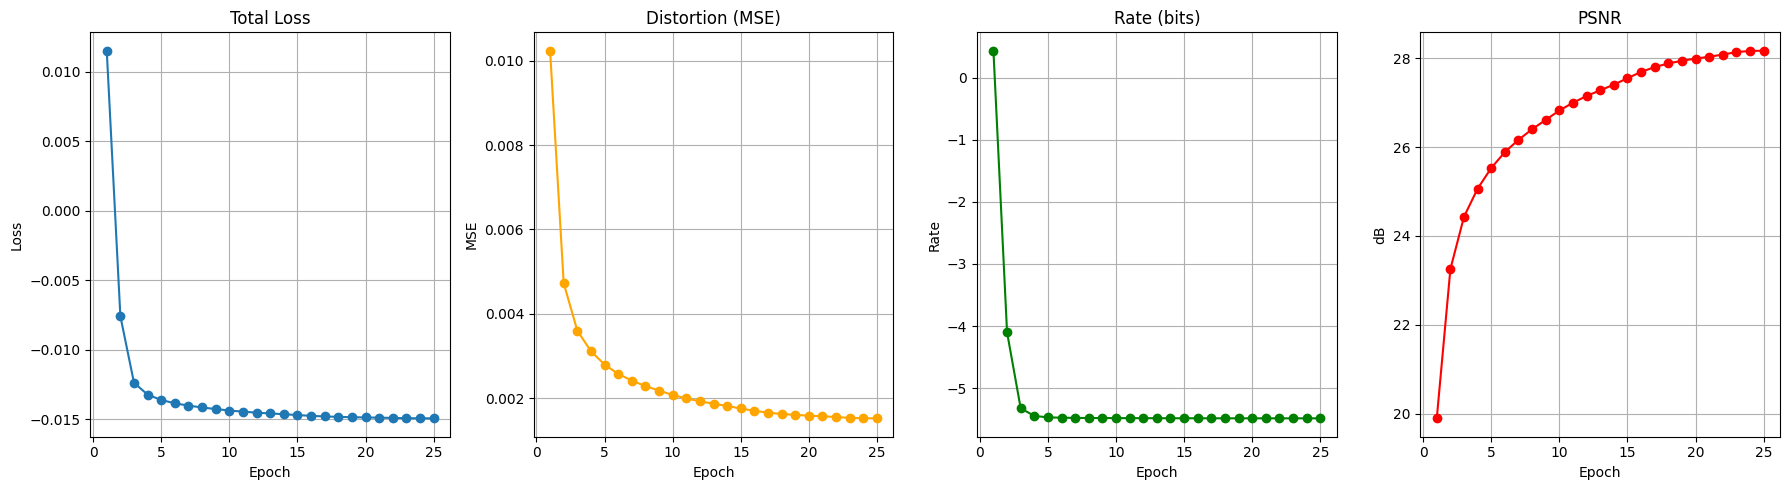


STARTING TESTING...

TESTING MODEL

1. Loading 10 frames...
   Video shape: torch.Size([10, 3, 128, 128])

2. Loading model from video_compression_best.pth...

3. Running inference...

TEST RESULTS:
  Distortion (MSE): 0.00155790
  PSNR: 28.07 dB
  Rate: -5.487817
  Total Loss: -0.025881

✓✓✓ ALL DONE! ✓✓✓


In [ ]:
if __name__ == "__main__":

    print("\n" + "="*70)
    print("DEEP VIDEO COMPRESSION")
    print("="*70)

    CONFIG = {
        'video_path': '/content/Me at the zoo.mp4',
        'num_epochs': 25,
        'max_frames': 30,
        'chunk_size': 10,
        'sequence_length': 4,
        'alpha': 0.003,
        'latent_channels':24,
        'learning_rate': 5e-4
    }

    print("\nConfiguration:")
    for key, value in CONFIG.items():
        print(f"  {key}: {value}")

    try:
        print("\n" + "="*70)
        print("STARTING TRAINING...")
        print("="*70)

        model = train_with_chunks(**CONFIG)

        print("\n" + "="*70)
        print("STARTING TESTING...")
        print("="*70)

        reconstructed = test_model(
            video_path=CONFIG['video_path'],
            model_path='video_compression_best.pth',
            num_test_frames=10,
            latent_channels=CONFIG['latent_channels']
        )

        print("\n" + "="*70)
        print("✓✓✓ ALL DONE! ✓✓✓")
        print("="*70)

    except Exception as e:
        print(f"\n{'='*70}")
        print("✗✗✗ ERROR ✗✗✗")
        print(f"{'='*70}")
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()


In [ ]:
def load_video_frames(video_path, start_frame=0, num_frames=10, target_size=(128, 128)):
    """Load video frames"""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frames = []
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV) #yuv changed
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return None

    frames_array = np.stack(frames)
    frames_tensor = torch.from_numpy(frames_array).permute(0, 3, 1, 2)
    return frames_tensor


def save_video_file(frames, output_path, fps=10):
    """
    Save frames as video file

    Args:
        frames: torch.Tensor [num_frames, C, H, W] in range [0, 1]
        output_path: Path to save video
        fps: Frames per second
    """
    frames_np = frames.cpu().numpy()
    frames_np = np.transpose(frames_np, (0, 2, 3, 1))  # [N, H, W, C]
    frames_np = (frames_np * 255).astype(np.uint8)

    height, width = frames_np.shape[1:3]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames_np:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_YUV2BGR)
        out.write(frame_bgr)

    out.release()
    print(f"✓ Video saved: {output_path}")


def create_side_by_side_video(original, reconstructed, output_path, fps=10):
    """
    Create side-by-side comparison video

    Args:
        original: torch.Tensor [num_frames, C, H, W]
        reconstructed: torch.Tensor [num_frames, C, H, W]
        output_path: Path to save video
        fps: Frames per second
    """
    orig_np = original.cpu().numpy().transpose(0, 2, 3, 1)
    recon_np = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)

    orig_np = (orig_np * 255).astype(np.uint8)
    recon_np = (recon_np * 255).astype(np.uint8)

    num_frames = orig_np.shape[0]
    height, width = orig_np.shape[1:3]

    # Create side-by-side frames with labels
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width * 2 + 20, height + 60))

    for i in range(num_frames):
        # Create canvas
        canvas = np.ones((height + 60, width * 2 + 20, 3), dtype=np.uint8) * 255

        # Add frames
        canvas[40:40+height, 0:width] = orig_np[i]
        canvas[40:40+height, width+20:width*2+20] = recon_np[i]

        # Add labels
        cv2.putText(canvas, "Original", (width//2 - 40, 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(canvas, "Reconstructed", (width + 20 + width//2 - 60, 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # Calculate MSE for this frame
        mse = np.mean((orig_np[i].astype(float) - recon_np[i].astype(float)) ** 2) / 255**2
        psnr = 10 * np.log10(1.0 / (mse + 1e-10))

        cv2.putText(canvas, f"PSNR: {psnr:.2f} dB", (width + 10, height + 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 128, 0), 1)

        canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_YUV2BGR)
        out.write(canvas_bgr)

    out.release()
    print(f"✓ Side-by-side video saved: {output_path}")


def visualize_reconstructed_video(
    video_path='/content/video.mp4',
    model_path='video_compression_best.pth',
    num_frames=10,
    latent_channels=24,
    fps=10,
    output_dir='video_results'
):
    """
    Complete video visualization pipeline

    Creates:
    - original.mp4: Original video
    - reconstructed.mp4: Reconstructed video
    - comparison.mp4: Side-by-side comparison
    - grid_animation.gif: Animated grid
    """

    print("="*70)
    print("VIDEO RECONSTRUCTION VISUALIZER")
    print("="*70)

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # 1. Load video
    print(f"\n1. Loading {num_frames} frames from video...")
    original_frames = load_video_frames(video_path, num_frames=num_frames)

    if original_frames is None:
        print("Error: Could not load video")
        return

    print(f"   Loaded: {original_frames.shape}")

    # 2. Load model
    print(f"\n2. Loading model from {model_path}...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = VideoCompression(latent_channels=latent_channels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    print(f"   Model loaded on {device}")

    # 3. Run inference
    print(f"\n3. Running inference...")
    with torch.no_grad():
        batch = original_frames.unsqueeze(0).to(device)
        reconstructed, loss, distortion, rate = model(batch, alpha=0.005)
        reconstructed = reconstructed.squeeze(0).cpu()

    original_frames = original_frames.cpu()

    # 4. Calculate metrics
    print(f"\n4. Calculating metrics...")
    mse = torch.mean((original_frames - reconstructed) ** 2).item()
    psnr = 10 * np.log10(1.0 / (mse + 1e-10))

    print(f"\n{'='*70}")
    print("OVERALL METRICS:")
    print(f"  MSE:  {mse:.8f}")
    print(f"  PSNR: {psnr:.2f} dB")
    print(f"  Rate: {rate.item():.6f}")
    print(f"{'='*70}")

    # 5. Create visualizations
    print(f"\n5. Creating video files...")

    # Original video
    orig_path = os.path.join(output_dir, 'original.mp4')
    save_video_file(original_frames, orig_path, fps)

    # Reconstructed video
    recon_path = os.path.join(output_dir, 'reconstructed.mp4')
    save_video_file(reconstructed, recon_path, fps)

    # Side-by-side comparison
    comparison_path = os.path.join(output_dir, 'comparison.mp4')
    create_side_by_side_video(original_frames, reconstructed, comparison_path, fps)


    print(f"\n{'='*70}")
    print("✓✓✓ VISUALIZATION COMPLETE! ✓✓✓")
    print(f"{'='*70}")
    print(f"\nAll files saved in: {output_dir}/")
    print(f"  - original.mp4")
    print(f"  - reconstructed.mp4")
    print(f"  - comparison.mp4")
    print(f"{'='*70}")


    return original_frames, reconstructed




In [ ]:
if __name__ == "__main__":

    # Run visualization
    original, reconstructed = visualize_reconstructed_video(
        video_path= '/content/Me at the zoo.mp4',
        model_path='video_compression_best.pth',
        num_frames=30,
        latent_channels=24,
        fps=10,
        output_dir='video_results'
    )

    print("="*70)

VIDEO RECONSTRUCTION VISUALIZER

1. Loading 30 frames from video...
   Loaded: torch.Size([30, 3, 128, 128])

2. Loading model from video_compression_best.pth...
   Model loaded on cuda

3. Running inference...

4. Calculating metrics...

OVERALL METRICS:
  MSE:  0.00147206
  PSNR: 28.32 dB
  Rate: -5.488288

5. Creating video files...
✓ Video saved: video_results/original.mp4
✓ Video saved: video_results/reconstructed.mp4
✓ Side-by-side video saved: video_results/comparison.mp4

✓✓✓ VISUALIZATION COMPLETE! ✓✓✓

All files saved in: video_results/
  - original.mp4
  - reconstructed.mp4
  - comparison.mp4
